# Yellow-billed Cuckoo - GBIF Records Summary

## General Setup

In [1]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()

### Config file
Some of the scripts below pull common variables from a config file.  This is so in order to reduce redundancy and also facilitates running scripts outside of jupyter notebooks.  However, variables need to be able to be set in notebooks too, so the cell below deletes and then rewrites the config file according to what you want for this notebook.

In [2]:
# Set variables in the following text string, not variable assignment below.
text = """#NOTE! this is overwritten by some notebooks, so update everywhere, if adding lines.
sp_id = 'bybcux0'
summary_name = 'cuckoo'
gbif_req_id = 'GBIFr11'
gbif_filter_id = 'GBIFf3'
ebird_req_id = None
ebird_filter_id = None
evaluation = 'eval_gbif1'
workDir = '/Users/nmtarr/Documents/RANGES/'
codeDir = '/Users/nmtarr/Code/range_map_evaluation/'
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
default_coordUncertainty = 1000
SRID_dict = {'WGS84': 4326, 'AlbersNAD83': 102008} # Used in file names for output.
spdb = outDir + sp_id + gbif_req_id + gbif_filter_id + '.sqlite'
"""
f = open('config.py', 'w')
f.write(text)
f.close()

import config
species_id = config.sp_id
summary_name = config.summary_name
request_id = config.gbif_req_id
filter_id = config.gbif_filter_id
inDir = config.inDir
outDir = config.outDir
common_name = 'Yellow-billed Cuckoo'

In [3]:
connjup = sqlite3.connect(config.codeDir + 'parameters.sqlite')
cursorjup = connjup.cursor()

## Species Concept

In [4]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': '4,5,6,7,8',
 'common_name': 'yellow-billed cuckoo',
 'detection_distance_meters': 100,
 'end_year': None,
 'error_tolerance': 40,
 'fws_id': None,
 'gap_id': 'bybcux',
 'gbif_id': '2496287',
 'geometry': None,
 'itis_tsn': '177831',
 'migratory': '1',
 'notes': 'Manually entered for use in development. ',
 'pad': 2,
 'scientific_name': 'Coccyzus americanus',
 'species_id': 'bybcux0',
 'start_year': None,
 'wintering_months': '11,12,1,2'}


## Filters

In [5]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(request_id), con=connjup)
print("THE REQUEST FILTER SET")
print(df1.loc[0])

THE REQUEST FILTER SET
request_id                                                          GBIFr11
source                                                                 GBIF
lat_range                                                             27,41
lon_range                                                           -91,-75
years_range                                                       1990,1991
months_range                                                            4,8
geoissue                                                               None
coordinate                                                             True
continent                                                              None
creator                                                             N. Tarr
notes           Used in development.  Should run quickly but provide som...
Name: 0, dtype: object


In [6]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(df2.loc[0])

THE POST REQUEST FILTER SET
filter_id                                                                          GBIFf3
dataset                                                                              GBIF
collection_codes_omit                                                  EBIRD_NJ, EBIRD_NH
institutions_omit                                                               OMNH, ROM
has_coordinate_uncertainty                                                              0
max_coordinate_uncertainty                                                           1000
bases_omit                                                    PRESERVED_SPECIMEN, UNKNOWN
protocols_omit                                                       BIOCASE, DWC_ARCHIVE
sampling_protocols_omit                                                                  
issues_omit                                    COORDINATE_ROUNDED, GEODETIC_DATUM_INVALID
creator                                                                 

## Run Query

In [7]:
# Run a script that retrieves and filters
%run 'retrieve_occurrences.py'

downloading https://www.sciencebase.gov/catalog/file/get/59f5e201e4b063d5d307dc0f?f=__disk__89%2Fbb%2F19%2F89bb19045ef553fdf3a05056b81618649e77e351 to /Users/nmtarr/Documents/RANGES/Inputs/bYBCUx_CONUS_Range_2001v1.zip
downloading https://www.sciencebase.gov/catalog/file/get/59f5e201e4b063d5d307dc0f?f=__disk__db%2Fb5%2F9a%2Fdbb59a7ae14e77d87bd9a6f527f91dd55e577628 to /Users/nmtarr/Documents/RANGES/Inputs/bYBCUx_CONUS_Range_2001v1.xml
1817 records exist
0
1000
<class 'int'>
['EBIRD_NJ', 'EBIRD_NH']
<class 'list'>
['OMNH', 'ROM']
<class 'list'>
['PRESERVED_SPECIMEN', 'UNKNOWN']
<class 'list'>
['BIOCASE', 'DWC_ARCHIVE']
<class 'list'>
['']
<class 'list'>


## Results

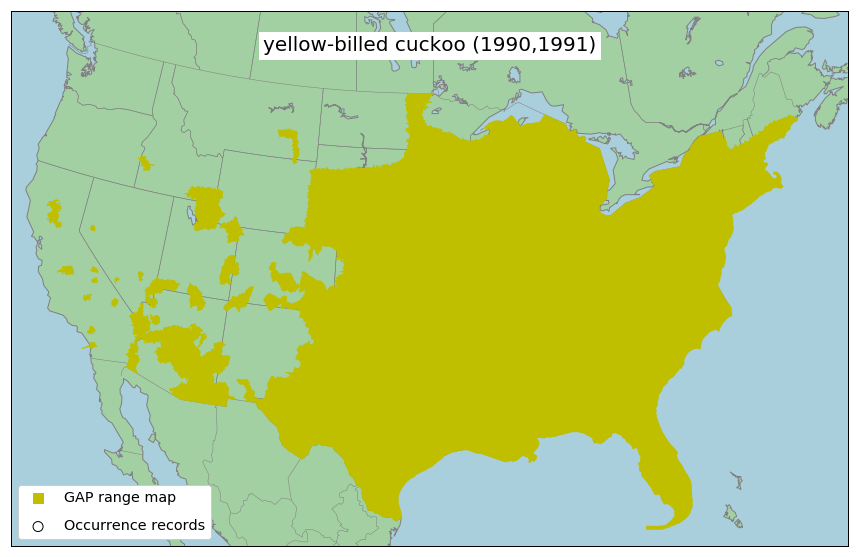

In [8]:
gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

shp1 = {'file': gap_range2, 'column': None, 'alias': 'GAP range map',
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y', 'marker':'s'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
if os.path.isfile(gap_range2 + ".shp"):
    map_these=[shp1, shp2]
else:
    map_these=[shp2]
    
title="{1} ({0})".format(years, common_name)
functions.MapShapefilePolygons(map_these=map_these, title=title)

### Where were records retrieved from?

In [9]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [request_id, filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

GBIF


### How many records made it through the filters?

In [10]:
conn_occ= sqlite3.connect(config.spdb)
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records made it through the filters")

2 records made it through the filters


### What years were represented in the data?

Text(0.5, 1.0, 'Occurrences per Year')

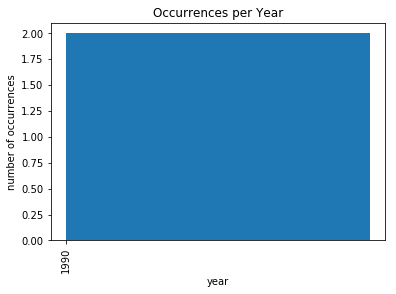

In [11]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
years = connjup.execute("SELECT years_range FROM gbif_requests WHERE request_id = '{0}'".format(config.gbif_req_id)).fetchone()[0]
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of occurrences")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### What months were represented in the data?

Text(0.5, 1.0, 'Occurrences per Month')

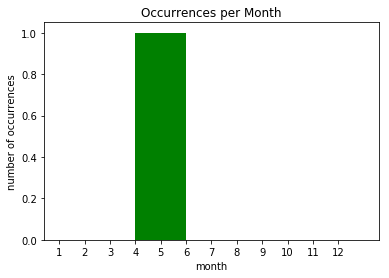

In [12]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of occurrences")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### What is the distribution of coordinate uncertainty values?

Text(0.5, 1.0, 'Coordinate Uncertainty')

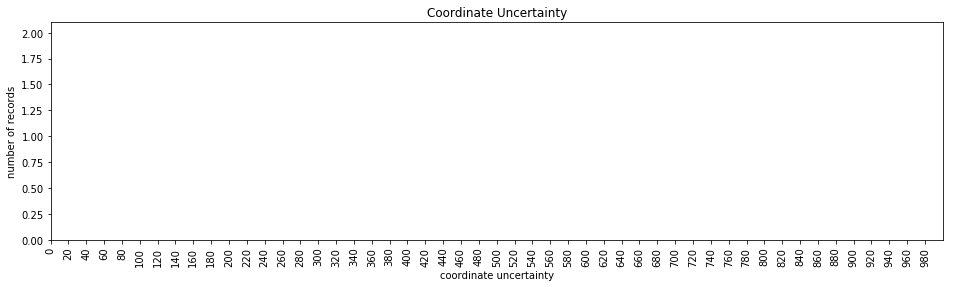

In [13]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty')

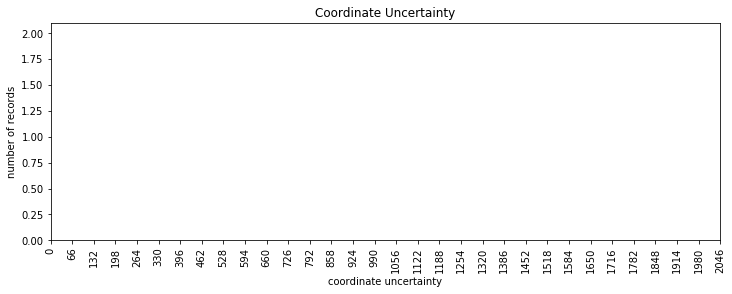

In [14]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

### What geodetic datums were present in the data?

In [15]:
datums = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'datums';").fetchone()[0]
datums = datums.replace('[', '').strip().replace(']', '').replace("'", "")
datums = datums.split()
for datum in datums:
    print(datum)

WGS84


### What issues were present in the data?

In [16]:
issues = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'issues';").fetchone()[0]
issues = issues.replace('[', '').strip().replace(']', '').replace("'", "")
issues = issues.split(',')
for iss in issues:
    print(iss.strip())

GEODETIC_DATUM_ASSUMED_WGS84


### What were the bases of the records?

In [17]:
bases = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'bases';").fetchone()[0]
bases = bases.replace('[', '').strip().replace(']', '').replace("'", "")
bases = bases.split(",")
for bas in bases:
    print(bas.strip())

OBSERVATION


### What were the establishment means?

In [18]:
establishment = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'establishment';").fetchall()[0]
for est in establishment:
    est = est.replace('[', '').strip().replace(']', '').replace("'", "")
    print(est)

### What identification qualifiers were returned?

In [19]:
quali = curs_occ.execute("SELECT DISTINCT vals FROM values_of_interest WHERE field = 'IDqualifier';").fetchall()[0]
for q in quali:
    q = q.replace('[', '').strip().replace(']', '').replace("'", "")
    print(q)

### What protocols and sampling protocols were included?

In [20]:
protos = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'protocols';").fetchall()[0]
for pro in protos:
    pro = pro.replace('[', '').strip().replace(']', '').replace("'", "")
    print(pro)

DIGIR


### What unique remarks were included?

In [21]:
remarks = curs_occ.execute("SELECT DISTINCT remarks FROM occurrences;").fetchall()
#remarks = remarks.replace('[', '').strip().replace(']', '').replace("'", "")
#remarks = remarks.split(',')
if len(remarks) <= 20:
    for rem in remarks:
        if rem[0][0:1] == ';':
            print(rem[0][2:])
        else:
            print(rem[0])
else:
    print("More than 20 remarks, consult the occurrence database")

Palenque, zona arqueológica
Cordón Cruz Verde, 1.5 km SW de Jolnopa Guadalupe


### What institutions provided the records?

In [22]:
institutions = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'institutions';").fetchone()[0]
institutions = institutions.replace('[', '').strip().replace(']', '').replace("'", "")
institutions = institutions.split(',')
for ins in institutions:
    print(ins.strip())

ND


### What data collections were included?

In [23]:
collections = curs_occ.execute("SELECT vals FROM values_of_interest WHERE field = 'collections';").fetchone()[0]
collections = collections.replace('[', '').strip().replace(']', '').replace("'", "")
collections = collections.split(',')
for colls in collections:
    print(colls.strip())

ND


### Were there duplicate records?

In [24]:
dups0 = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences GROUP BY geom_xy4326, occurrenceDate;").fetchall()
dups1 = [x[0] for x in dups0]
dups2 = [x for x in dups1 if x > 1]
print(str(len(dups2)) + ' records were duplicates based on xy coordinate and date-time')

0 records were duplicates based on xy coordinate and date-time


### What keys/fields were returned for the records?

In [25]:
fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", conn_occ, index_col='index')
fields_summary.index.name = 'field'
print(fields_summary)

                        included(n)  populated(n)
field                                            
acceptedScientificName            2             2
acceptedTaxonKey                  2             2
basisOfRecord                     2             2
collectionCode                    2             2
dataGeneralizations               2             0
day                               2             2
decimalLatitude                   2             2
decimalLongitude                  2             2
eventDate                         2             2
gbifID                            2             2
geodeticDatum                     2             2
institutionCode                   2             2
issues                            2             2
locality                          2             2
month                             2             2
protocol                          2             2
remarks                           2             2
scientificName                    2             2


### Runtime

In [26]:
t2 = datetime.now()
print(t2 - t1)

0:00:42.112508
